## Benchmark loading CELLxGENE Census data in Pytorch

Run this notebook via [Papermill](https://papermill.readthedocs.io/en/latest/) / the [`execute-nb`](https://github.com/ryan-williams/arrayloader-benchmarks/blob/main/execute-nb) wrapper

```bash
./execute-nb us-east-1  # from a g4dn.8xlarge in us-east-1
./execute-nb us-west-2  # from a g4dn.8xlarge in us-west-2
./execute-nb local-nvme -p census_uri '/mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma'
./execute-nb subset-nvme -p experiment_uri '/mnt/nvme/census-benchmark_2:7' -p n_vars 0  # 20k vars already sliced
./execute-nb subset-gp3 -p experiment_uri 'data/census-benchmark_2:7' -p n_vars 0  # 20k vars already sliced
```
See [README](https://github.com/ryan-williams/arrayloader-benchmarks?tab=readme-ov-file#census-timing-vs-data-locality) for more info.

In [1]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from benchmark import *
from utils import *

**⚠️ This notebook was run with a modified `cellxgene_census` library; see [`main...ryan-williams:cellxgene-census`](https://github.com/chanzuckerberg/cellxgene-census/compare/main...ryan-williams:cellxgene-census:stats?expand=1) ⚠️**

In [2]:
from cellxgene_census.experimental.ml import ExperimentDataPipe, experiment_dataloader
from cellxgene_census.experimental.ml.pytorch import pytorch_logger
import torch
from torch.utils.data import DataLoader
torch.ones(2).cuda();

### [Papermill](https://papermill.readthedocs.io/en/latest/) params:

In [3]:
# Set this to read from a local path
experiment_uri = '../data/census-benchmark_2:7'

# None ⟹ fetch from S3
census_uri = None
#census_uri = '/mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma'
census_version = "2023-12-15"

# By default:
# - `subset` if `experiment_uri` is a local path
# - `local` if `census_uri` is a local path
# - current (EC2 instance) region if `census_uri` is None (e.g. `us-east-1`, `us-west-2`)
name = 'subset-gp3-dbg'

collection_id = '283d65eb-dd53-496d-adb7-7570c7caa443'
# Slice datasets from `collection_id`
start = 2
end = 7

n_epochs = 1
batch_size = 1024

# Defaults to 20_000 when fetching from S3. Local subsets (when `experiment_uri` is set)
# are assumed to have already been var-sliced.
n_vars = None

soma_chunk_size = 10_000
gc_freq: Optional[int] = None  # When set, run `gc.collect()` every `gc_freq` batches
exclude_first_batch = True
progress_bar = True
torch_log_level = "DEBUG"

# Plot configs
ann_cutoff = .5  # Annotate plot with values for batch timings greater than this threshold
log_plot = False
width = 1200
height = 700

In [4]:
# Parameters
name = "subset-gp3"
progress_bar = False


In [5]:
pytorch_logger.setLevel(torch_log_level)

In [6]:
if experiment_uri:
    err(f"Loading experiment {experiment_uri}")
    with profile('open'):
        experiment = Experiment.open(experiment_uri)
    obs_query = None
    var_query = None
    if name is None:
        scheme = urlparse(experiment_uri).scheme
        if is_local(experiment_uri):
            name = 'subset'
else:
    if not census_uri:
        census_uri = None
    
    if name is None:
        if census_uri and is_local(census_uri):
            name = 'local'
        else:
            name = get_region()
    
    err(f"Loading census ({name})")

    with profile('open_soma'):
        census = cellxgene_census.open_soma(uri=census_uri, census_version=census_version)
    
    datasets = get_datasets(census, collection_id, 'datasets')
    err(f"{len(datasets)} datasets: {datasets[:10]}")
    
    experiment = census["census_data"]["homo_sapiens"]
    ds = datasets[slice(start, end)]
    datasets_query = "dataset_id in " + str(ds)
    obs_query = AxisQuery(value_filter=datasets_query)
    if n_vars is None:
        n_vars = 20_000
    var_query = AxisQuery(coords=(slice(n_vars - 1),)) if n_vars else None

if not name:
    raise ValueError("`name` not set")

experiment

Loading experiment ../data/census-benchmark_2:7


<Experiment '../data/census-benchmark_2:7' (open for 'r') (2 items)
    'obs': 'file:///home/ec2-user/arrayloader-benchmarks/data/census-benchmark_2:7/obs' (unopened)
    'ms': 'file:///home/ec2-user/arrayloader-benchmarks/data/census-benchmark_2:7/ms' (unopened)>

In [7]:
%%time
with profile('get_exp_datapipe'):
    experiment_datapipe = ExperimentDataPipe(
        experiment,
        measurement_name="RNA",
        X_name="raw",
        obs_query=obs_query,
        var_query=var_query,
        batch_size=batch_size,
        shuffle=True,
        soma_chunk_size=soma_chunk_size,
    )
    loader = experiment_dataloader(experiment_datapipe)
exp = Exp(experiment_datapipe, loader)
exp

CPU times: user 4.46 ms, sys: 100 µs, total: 4.56 ms
Wall time: 3.97 ms


Exp(datapipe=ExperimentDataPipe, loader=<torch.utils.data.dataloader.DataLoader object at 0x7f22cc65ce50>)

In [8]:
%%time
for _ in iter(loader): pass


Initializing ExperimentDataPipe
Initializing encoders
Using self.soma_chunk_size=10000
Shuffling 133790 obs joinids into 14 chunks of 10000
Process 22812 handling partition 1 of 1, partition_size=133790
Retrieving next SOMA chunk...
gc:  pre=(pfullmem(rss=1974542336, vms=24839561216, shared=613380096, text=3342336, lib=0, data=4876451840, dirty=0, uss=1958879232, pss=1966650368, swap=0), svmem(total=133636747264, available=129761320960, percent=2.9, used=2595643392, free=122641162240, active=8272035840, inactive=1446301696, buffers=2138112, cached=8397803520, shared=13172736, slab=587264000), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
gc: post=(pfullmem(rss=1976627200, vms=25923792896, shared=613429248, text=3342336, lib=0, data=5998247936, dirty=0, uss=1963638784, pss=1971409920, swap=0), svmem(total=133636747264, available=129759531008, percent=2.9, used=2597433344, free=122639372288, active=8275689472, inactive=1446301696, buffers=2138112, cached=8397803520, shared=

pytorch CxG iterator next start: 6456.429060835
SOMA-READ start: 6456.431237307
SOMA-READ duration: 6456.431297281
pytorch CxG iterator next end duration: 0.0026206829998045578
pytorch CxG iterator next start: 6456.587015
SOMA-READ start: 6456.588948119
SOMA-READ duration: 6456.589002803
pytorch CxG iterator next end duration: 0.0023640549998162896


gc:  pre=(pfullmem(rss=1980612608, vms=24850046976, shared=614850560, text=3342336, lib=0, data=4952113152, dirty=0, uss=1968201728, pss=1975972864, swap=0), svmem(total=133636747264, available=129755557888, percent=2.9, used=2601406464, free=122635399168, active=8279756800, inactive=1446301696, buffers=2138112, cached=8397803520, shared=13172736, slab=586231808), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
gc: post=(pfullmem(rss=1981181952, vms=24850046976, shared=614850560, text=3342336, lib=0, data=4970901504, dirty=0, uss=1970126848, pss=1977897984, swap=0), svmem(total=133636747264, available=129754726400, percent=2.9, used=2602237952, free=122634567680, active=8281133056, inactive=1446301696, buffers=2138112, cached=8397803520, shared=13172736, slab=586231808), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
Retrieved SOMA chunk totals: self.n_soma_chunks=0, self.n_obs=0, self.nnz=0, elapsed=0:00:00, gc_elapsed=0:00:00.342554
Retrieving next SOMA chunk

pytorch CxG iterator next start: 6456.746816859
SOMA-READ start: 6456.74874636
SOMA-READ duration: 6456.748810805
pytorch CxG iterator next end duration: 0.0023972569997567916
pytorch CxG iterator next start: 6456.906040571
SOMA-READ start: 6456.907973315
SOMA-READ duration: 6456.908047803
pytorch CxG iterator next end duration: 0.0024137070004144334


gc:  pre=(pfullmem(rss=1983152128, vms=25923792896, shared=614850560, text=3342336, lib=0, data=6045495296, dirty=0, uss=1971843072, pss=1979614208, swap=0), svmem(total=133636747264, available=129750315008, percent=2.9, used=2606649344, free=122630172672, active=8288272384, inactive=1446285312, buffers=2138112, cached=8397787136, shared=13172736, slab=585420800), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
gc: post=(pfullmem(rss=1982697472, vms=24850046976, shared=614850560, text=3342336, lib=0, data=4977704960, dirty=0, uss=1972105216, pss=1979876352, swap=0), svmem(total=133636747264, available=129750061056, percent=2.9, used=2606903296, free=122629918720, active=8287940608, inactive=1446285312, buffers=2138112, cached=8397787136, shared=13172736, slab=585420800), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
Retrieved SOMA chunk totals: self.n_soma_chunks=0, self.n_obs=0, self.nnz=0, elapsed=0:00:00, gc_elapsed=0:00:00.569542
Retrieving next SOMA chunk

pytorch CxG iterator next start: 6457.065337601
SOMA-READ start: 6457.067250429
SOMA-READ duration: 6457.067302706
pytorch CxG iterator next end duration: 0.002344818000892701
pytorch CxG iterator next start: 6457.222180027
SOMA-READ start: 6457.22410901
SOMA-READ duration: 6457.224161425
pytorch CxG iterator next end duration: 0.0024025439997785725


gc:  pre=(pfullmem(rss=1983455232, vms=25923792896, shared=614850560, text=3342336, lib=0, data=6051508224, dirty=0, uss=1972826112, pss=1980597248, swap=0), svmem(total=133636747264, available=129749299200, percent=2.9, used=2607665152, free=122629156864, active=8288694272, inactive=1446285312, buffers=2138112, cached=8397787136, shared=13172736, slab=585420800), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
gc: post=(pfullmem(rss=1983348736, vms=24850046976, shared=614850560, text=3342336, lib=0, data=4980772864, dirty=0, uss=1972940800, pss=1980711936, swap=0), svmem(total=133636747264, available=129748664320, percent=2.9, used=2608300032, free=122628521984, active=8288808960, inactive=1446285312, buffers=2138112, cached=8397787136, shared=13172736, slab=585420800), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
Retrieved SOMA chunk totals: self.n_soma_chunks=0, self.n_obs=0, self.nnz=0, elapsed=0:00:00, gc_elapsed=0:00:00.793639
Retrieving next SOMA chunk

pytorch CxG iterator next start: 6457.38194219
SOMA-READ start: 6457.383973816
SOMA-READ duration: 6457.384042113
pytorch CxG iterator next end duration: 0.0025030779997905483
pytorch CxG iterator next start: 6457.536968378
SOMA-READ start: 6457.538871943
SOMA-READ duration: 6457.538926675
pytorch CxG iterator next end duration: 0.0023661389996050275


gc:  pre=(pfullmem(rss=1984286720, vms=25923792896, shared=614850560, text=3342336, lib=0, data=6054518784, dirty=0, uss=1973542912, pss=1981314048, swap=0), svmem(total=133636747264, available=129748377600, percent=2.9, used=2608586752, free=122628235264, active=8289648640, inactive=1446285312, buffers=2138112, cached=8397787136, shared=13172736, slab=585420800), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
gc: post=(pfullmem(rss=1984221184, vms=24850046976, shared=614850560, text=3342336, lib=0, data=4983791616, dirty=0, uss=1973850112, pss=1981623296, swap=0), svmem(total=133636747264, available=129747869696, percent=2.9, used=2609094656, free=122627727360, active=8289005568, inactive=1446285312, buffers=2138112, cached=8397787136, shared=13172736, slab=585330688), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
Retrieved SOMA chunk totals: self.n_soma_chunks=0, self.n_obs=0, self.nnz=0, elapsed=0:00:00, gc_elapsed=0:00:01.012194
Retrieving next SOMA chunk

pytorch CxG iterator next start: 6457.692399599
SOMA-READ start: 6457.694313059
SOMA-READ duration: 6457.694363511
pytorch CxG iterator next end duration: 0.002367854999647534
pytorch CxG iterator next start: 6457.849898325
SOMA-READ start: 6457.85182081
SOMA-READ duration: 6457.851870665
pytorch CxG iterator next end duration: 0.0023887329998615314


gc:  pre=(pfullmem(rss=1984794624, vms=25923792896, shared=614850560, text=3342336, lib=0, data=6057537536, dirty=0, uss=1974145024, pss=1981918208, swap=0), svmem(total=133636747264, available=129747419136, percent=2.9, used=2609545216, free=122627276800, active=8289837056, inactive=1446285312, buffers=2138112, cached=8397787136, shared=13172736, slab=585330688), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
gc: post=(pfullmem(rss=1984380928, vms=24850046976, shared=614850560, text=3342336, lib=0, data=4983795712, dirty=0, uss=1974095872, pss=1981869056, swap=0), svmem(total=133636747264, available=129747419136, percent=2.9, used=2609545216, free=122627276800, active=8289431552, inactive=1446285312, buffers=2138112, cached=8397787136, shared=13172736, slab=585330688), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
Retrieved SOMA chunk totals: self.n_soma_chunks=0, self.n_obs=0, self.nnz=0, elapsed=0:00:00, gc_elapsed=0:00:01.236940
Retrieving next SOMA chunk

pytorch CxG iterator next start: 6458.008876987
SOMA-READ start: 6458.010818877
SOMA-READ duration: 6458.010867143
pytorch CxG iterator next end duration: 0.0023868710004535387
pytorch CxG iterator next start: 6458.163292106
SOMA-READ start: 6458.165205529
SOMA-READ duration: 6458.165254704
pytorch CxG iterator next end duration: 0.002366841999901226


gc:  pre=(pfullmem(rss=1985748992, vms=25923792896, shared=615243776, text=3342336, lib=0, data=6057541632, dirty=0, uss=1974583296, pss=1982356480, swap=0), svmem(total=133636747264, available=129747038208, percent=2.9, used=2609926144, free=122626895872, active=8290115584, inactive=1446285312, buffers=2138112, cached=8397787136, shared=13172736, slab=585330688), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
gc: post=(pfullmem(rss=1985363968, vms=24850046976, shared=615243776, text=3342336, lib=0, data=4983828480, dirty=0, uss=1974489088, pss=1982262272, swap=0), svmem(total=133636747264, available=129747165184, percent=2.9, used=2609799168, free=122627022848, active=8289570816, inactive=1446285312, buffers=2138112, cached=8397787136, shared=13172736, slab=585330688), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
Retrieved SOMA chunk totals: self.n_soma_chunks=0, self.n_obs=0, self.nnz=0, elapsed=0:00:00, gc_elapsed=0:00:01.458072
Retrieving next SOMA chunk

pytorch CxG iterator next start: 6458.319377375
SOMA-READ start: 6458.321343159
SOMA-READ duration: 6458.321391869
pytorch CxG iterator next end duration: 0.0024165739996533375
pytorch CxG iterator next start: 6458.477563238
SOMA-READ start: 6458.479452715
SOMA-READ duration: 6458.479503964
pytorch CxG iterator next end duration: 0.0023377820007226546


gc:  pre=(pfullmem(rss=1984749568, vms=24850046976, shared=615243776, text=3342336, lib=0, data=4983828480, dirty=0, uss=1973964800, pss=1981737984, swap=0), svmem(total=133636747264, available=129747349504, percent=2.9, used=2609672192, free=122627149824, active=8289034240, inactive=1446342656, buffers=2138112, cached=8397787136, shared=13172736, slab=585330688), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
gc: post=(pfullmem(rss=1984749568, vms=24850046976, shared=615243776, text=3342336, lib=0, data=4983828480, dirty=0, uss=1973968896, pss=1981742080, swap=0), svmem(total=133636747264, available=129747349504, percent=2.9, used=2609672192, free=122627149824, active=8289034240, inactive=1446342656, buffers=2138112, cached=8397787136, shared=13172736, slab=585330688), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
max process memory usage=1.839 GiB


CPU times: user 2.31 s, sys: 928 ms, total: 3.23 s
Wall time: 2.43 s


In [9]:
%%time
print(f"Data shape: {exp.datapipe.shape}, pid {os.getpid()}")

Data shape: (133790, 20000), pid 21081
CPU times: user 64 µs, sys: 15 µs, total: 79 µs
Wall time: 89.2 µs


## Run benchmark

In [10]:
%%time
epochs = []
for epoch in range(n_epochs):
    with profile(f'benchmark-epoch{epoch}'):
        epoch = benchmark(
            exp,
            batch_size=batch_size,
            gc_freq=gc_freq,
            exclude_first_batch=exclude_first_batch,
            progress_bar=progress_bar,
        )
    epochs.append(epoch)

results = Results(
    census=Method('census', epochs),
)

Using self.soma_chunk_size=10000
Shuffling 133790 obs joinids into 14 chunks of 10000
Process 15139 handling partition 1 of 1, partition_size=133790
Retrieving next SOMA chunk...
gc:  pre=(pfullmem(rss=2590298112, vms=31484096512, shared=617410560, text=3342336, lib=0, data=10439454720, dirty=0, uss=2581614592, pss=2589320192, swap=0), svmem(total=133636747264, available=129452879872, percent=3.1, used=3195768832, free=122106101760, active=8312836096, inactive=1949753344, buffers=2138112, cached=8332738560, shared=13172736, slab=578707456), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
gc: post=(pfullmem(rss=2289352704, vms=30206320640, shared=617410560, text=3342336, lib=0, data=8508985344, dirty=0, uss=2273951744, pss=2281646080, swap=0), svmem(total=133636747264, available=129643745280, percent=3.0, used=2888638464, free=122413232128, active=8120926208, inactive=1833488384, buffers=2138112, cached=8332738560, shared=13172736, slab=578576384), sswap(total=0, used=0, fre

SOMA-blockwise start: 0.007556838999789761
scipy start: 0.007749557999886747
pytorch CxG iterator next start: 0.007459693999862793


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=35898436, elapsed=0:00:04.255469
Retrieved SOMA chunk totals: self.n_soma_chunks=15, self.n_obs=143346, self.nnz=406486023, elapsed=0:00:50.843413, gc_elapsed=0:00:00.132823
Retrieving next SOMA chunk...


pytorch CxG iterator next end: 0.007606909000060114
SOMA-blockwise start: 0.00795178400039731
scipy start: 0.008139879999816912
pytorch CxG iterator next start: 0.01061470799959352


gc:  pre=(pfullmem(rss=5603323904, vms=38782246912, shared=617410560, text=3342336, lib=0, data=17207857152, dirty=0, uss=5572616192, pss=5580321792, swap=0), svmem(total=133636747264, available=126149439488, percent=5.6, used=6207524864, free=119094312960, active=11615428608, inactive=1658085376, buffers=2138112, cached=8332771328, shared=13172736, slab=576851968), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
gc: post=(pfullmem(rss=3607838720, vms=34657656832, shared=617410560, text=3342336, lib=0, data=13083267072, dirty=0, uss=3589042176, pss=3596747776, swap=0), svmem(total=133636747264, available=128148283392, percent=4.1, used=4208680960, free=121093156864, active=9619595264, inactive=1658085376, buffers=2138112, cached=8332771328, shared=13172736, slab=576851968), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=14032495, elapsed=0:00:02.066892
Retrieved SOMA chunk totals: self.n_soma

pytorch CxG iterator next end: 0.008620560000053956
SOMA-blockwise start: 0.010653658999672189
scipy start: 0.01060968399997364
pytorch CxG iterator next start: 0.010751604000233783


gc:  pre=(pfullmem(rss=4298510336, vms=38412279808, shared=617410560, text=3342336, lib=0, data=16838729728, dirty=0, uss=4288110592, pss=4295816192, swap=0), svmem(total=133636747264, available=127454924800, percent=4.6, used=4902031360, free=120399790080, active=10310406144, inactive=1658085376, buffers=2138112, cached=8332787712, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
gc: post=(pfullmem(rss=3258146816, vms=34758557696, shared=617410560, text=3342336, lib=0, data=13185007616, dirty=0, uss=3247763456, pss=3255469056, swap=0), svmem(total=133636747264, available=128495779840, percent=3.8, used=3861180416, free=121440641024, active=9270194176, inactive=1658089472, buffers=2138112, cached=8332787712, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=16207697, elapsed=0:00:02.205338
Retrieved SOMA chunk totals: self.n_soma

pytorch CxG iterator next end: 0.007463743000243994
SOMA-blockwise start: 0.01076335800007655
scipy start: 0.010755742000128521
pytorch CxG iterator next start: 0.010806123999827832


gc:  pre=(pfullmem(rss=5093036032, vms=38854266880, shared=617410560, text=3342336, lib=0, data=17280409600, dirty=0, uss=5083484160, pss=5091187712, swap=0), svmem(total=133636747264, available=126658871296, percent=5.2, used=5698093056, free=119603728384, active=11107008512, inactive=1658093568, buffers=2138112, cached=8332787712, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
gc: post=(pfullmem(rss=3822129152, vms=35215302656, shared=617410560, text=3342336, lib=0, data=13641445376, dirty=0, uss=3812577280, pss=3820280832, swap=0), svmem(total=133636747264, available=127930875904, percent=4.3, used=4426088448, free=120875732992, active=9836433408, inactive=1658093568, buffers=2138112, cached=8332787712, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9557, self.nnz=25249271, elapsed=0:00:03.271180
Retrieved SOMA chunk totals: self.n_soma

pytorch CxG iterator next end: 0.007462925000254472
SOMA-blockwise start: 0.010804623000240099
scipy start: 0.010760312999991584
pytorch CxG iterator next start: 0.010799481000049127


gc:  pre=(pfullmem(rss=5196189696, vms=38906736640, shared=617410560, text=3342336, lib=0, data=17333686272, dirty=0, uss=5188550656, pss=5196254208, swap=0), svmem(total=133636747264, available=126555422720, percent=5.3, used=5801541632, free=119500279808, active=11211878400, inactive=1658093568, buffers=2138112, cached=8332787712, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
gc: post=(pfullmem(rss=3567255552, vms=34976366592, shared=617410560, text=3342336, lib=0, data=13403316224, dirty=0, uss=3556741120, pss=3564444672, swap=0), svmem(total=133636747264, available=128188506112, percent=4.1, used=4168458240, free=121133363200, active=9580154880, inactive=1658093568, buffers=2138112, cached=8332787712, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=17489698, elapsed=0:00:02.350115
Retrieved SOMA chunk totals: self.n_soma

pytorch CxG iterator next end: 0.008013468999706674
SOMA-blockwise start: 0.010793222000302194
scipy start: 0.010697373000311927
pytorch CxG iterator next start: 0.010723711000082403


gc:  pre=(pfullmem(rss=4878852096, vms=38757216256, shared=617410560, text=3342336, lib=0, data=17184264192, dirty=0, uss=4869337088, pss=4877040640, swap=0), svmem(total=133636747264, available=126874161152, percent=5.1, used=5482803200, free=119819018240, active=10893488128, inactive=1658093568, buffers=2138112, cached=8332787712, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
gc: post=(pfullmem(rss=3625779200, vms=35088248832, shared=617410560, text=3342336, lib=0, data=13515296768, dirty=0, uss=3616260096, pss=3623963648, swap=0), svmem(total=133636747264, available=128128983040, percent=4.1, used=4227981312, free=121073840128, active=9639903232, inactive=1658093568, buffers=2138112, cached=8332787712, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=19339142, elapsed=0:00:02.449248
Retrieved SOMA chunk totals: self.n_soma

pytorch CxG iterator next end: 0.007584359000247787
SOMA-blockwise start: 0.010754353000265837
scipy start: 0.011408560999825568
pytorch CxG iterator next start: 0.010733457999776874


gc:  pre=(pfullmem(rss=5472018432, vms=39021928448, shared=617410560, text=3342336, lib=0, data=17448837120, dirty=0, uss=5462654976, pss=5470358528, swap=0), svmem(total=133636747264, available=126280556544, percent=5.5, used=6076407808, free=119225413632, active=11486359552, inactive=1658093568, buffers=2138112, cached=8332787712, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
gc: post=(pfullmem(rss=4019195904, vms=35331633152, shared=617410560, text=3342336, lib=0, data=13758541824, dirty=0, uss=4009832448, pss=4017536000, swap=0), svmem(total=133636747264, available=127734661120, percent=4.4, used=4622303232, free=120679518208, active=10034208768, inactive=1658093568, buffers=2138112, cached=8332787712, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=27197660, elapsed=0:00:03.465359
Retrieved SOMA chunk totals: self.n_som

pytorch CxG iterator next end: 0.007465761999810638
SOMA-blockwise start: 0.010764576999918063
scipy start: 0.01073117900023135
pytorch CxG iterator next start: 0.010757218000435387


gc:  pre=(pfullmem(rss=6432661504, vms=39490433024, shared=617410560, text=3342336, lib=0, data=17918369792, dirty=0, uss=6423937024, pss=6431642624, swap=0), svmem(total=133636747264, available=125315330048, percent=6.2, used=7041634304, free=118260183040, active=12450693120, inactive=1658097664, buffers=2138112, cached=8332791808, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
gc: post=(pfullmem(rss=4465352704, vms=35576254464, shared=617410560, text=3342336, lib=0, data=14004191232, dirty=0, uss=4456361984, pss=4464067584, swap=0), svmem(total=133636747264, available=127287062528, percent=4.8, used=5069901824, free=120231915520, active=10480275456, inactive=1658097664, buffers=2138112, cached=8332791808, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9557, self.nnz=33919521, elapsed=0:00:04.288138
Retrieved SOMA chunk totals: self.n_som

pytorch CxG iterator next end: 0.007460251999873435
SOMA-blockwise start: 0.0076279690001683775
scipy start: 0.0075067380003019935
pytorch CxG iterator next start: 0.008970579000106227


gc:  pre=(pfullmem(rss=6632321024, vms=39479881728, shared=617410560, text=3342336, lib=0, data=17908826112, dirty=0, uss=6624190464, pss=6631896064, swap=0), svmem(total=133636747264, available=125119430656, percent=6.4, used=7237533696, free=118064283648, active=12645933056, inactive=1658097664, buffers=2138112, cached=8332791808, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
gc: post=(pfullmem(rss=4510715904, vms=35416080384, shared=617410560, text=3342336, lib=0, data=13845024768, dirty=0, uss=4502581248, pss=4510286848, swap=0), svmem(total=133636747264, available=127243763712, percent=4.8, used=5113200640, free=120188616704, active=10524790784, inactive=1658097664, buffers=2138112, cached=8332791808, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9557, self.nnz=31183978, elapsed=0:00:03.714664
Retrieved SOMA chunk totals: self.n_som

pytorch CxG iterator next end: 0.007564946999991662
SOMA-blockwise start: 0.01014473800023552
scipy start: 0.010694375000184664
pytorch CxG iterator next start: 0.010646189999988565


gc:  pre=(pfullmem(rss=6575423488, vms=39451774976, shared=617410560, text=3342336, lib=0, data=17882050560, dirty=0, uss=6568382464, pss=6576088064, swap=0), svmem(total=133636747264, available=125174812672, percent=6.3, used=7182151680, free=118119665664, active=12590325760, inactive=1658097664, buffers=2138112, cached=8332791808, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
gc: post=(pfullmem(rss=4604977152, vms=35480887296, shared=617410560, text=3342336, lib=0, data=13911162880, dirty=0, uss=4597936128, pss=4605641728, swap=0), svmem(total=133636747264, available=127148306432, percent=4.9, used=5208657920, free=120093159424, active=10619793408, inactive=1658097664, buffers=2138112, cached=8332791808, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=33892022, elapsed=0:00:04.253510
Retrieved SOMA chunk totals: self.n_som

pytorch CxG iterator next end: 0.007475332000012713
SOMA-blockwise start: 0.010687478999898303
scipy start: 0.010674442999970779
pytorch CxG iterator next start: 0.010667741000361275


gc:  pre=(pfullmem(rss=6435078144, vms=39409635328, shared=617410560, text=3342336, lib=0, data=17840713728, dirty=0, uss=6428008448, pss=6435714048, swap=0), svmem(total=133636747264, available=125315014656, percent=6.2, used=7041949696, free=118259867648, active=12450148352, inactive=1658097664, buffers=2138112, cached=8332791808, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
gc: post=(pfullmem(rss=4284735488, vms=35313704960, shared=617410560, text=3342336, lib=0, data=13744783360, dirty=0, uss=4277665792, pss=4285371392, swap=0), svmem(total=133636747264, available=127468216320, percent=4.6, used=4888748032, free=120413069312, active=10300055552, inactive=1658097664, buffers=2138112, cached=8332791808, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9557, self.nnz=27269678, elapsed=0:00:03.350411
Retrieved SOMA chunk totals: self.n_som

pytorch CxG iterator next end: 0.007448273000136396
SOMA-blockwise start: 0.00756522399979076
scipy start: 0.007495268999718974
pytorch CxG iterator next start: 0.010788639000111289


gc:  pre=(pfullmem(rss=6126968832, vms=39276773376, shared=617410560, text=3342336, lib=0, data=17708654592, dirty=0, uss=6119612416, pss=6127318016, swap=0), svmem(total=133636747264, available=125843021824, percent=5.8, used=6732103680, free=118569713664, active=11923681280, inactive=1876258816, buffers=2138112, cached=8332791808, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
gc: post=(pfullmem(rss=4300001280, vms=35371462656, shared=617410560, text=3342336, lib=0, data=13803343872, dirty=0, uss=4292644864, pss=4300350464, swap=0), svmem(total=133636747264, available=127671615488, percent=4.5, used=4903510016, free=120398307328, active=10097160192, inactive=1876258816, buffers=2138112, cached=8332791808, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=29214437, elapsed=0:00:03.422676
Retrieved SOMA chunk totals: self.n_som

pytorch CxG iterator next end: 0.00748784200004593
SOMA-blockwise start: 0.010784391000015603
scipy start: 0.01066878000028737
pytorch CxG iterator next start: 0.01068082699976003


gc:  pre=(pfullmem(rss=6619918336, vms=39571701760, shared=617410560, text=3342336, lib=0, data=18004381696, dirty=0, uss=6613061632, pss=6620767232, swap=0), svmem(total=133636747264, available=125130350592, percent=6.4, used=7226613760, free=118075203584, active=12635389952, inactive=1658097664, buffers=2138112, cached=8332791808, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
gc: post=(pfullmem(rss=4585979904, vms=35630055424, shared=617410560, text=3342336, lib=0, data=14062735360, dirty=0, uss=4579123200, pss=4586828800, swap=0), svmem(total=133636747264, available=127166787584, percent=4.8, used=5190176768, free=120111640576, active=10601172992, inactive=1658097664, buffers=2138112, cached=8332791808, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9557, self.nnz=34774431, elapsed=0:00:04.363591
Retrieved SOMA chunk totals: self.n_som

pytorch CxG iterator next end: 0.00746365999975751
SOMA-blockwise start: 0.010714546999679442
scipy start: 0.010668668000107573
pytorch CxG iterator next start: 0.010651636000147846


gc:  pre=(pfullmem(rss=6354681856, vms=39446495232, shared=617410560, text=3342336, lib=0, data=17881477120, dirty=0, uss=6347972608, pss=6355678208, swap=0), svmem(total=133636747264, available=125393846272, percent=6.2, used=6963118080, free=118338699264, active=12372533248, inactive=1658097664, buffers=2138112, cached=8332791808, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
gc: post=(pfullmem(rss=4199133184, vms=35333988352, shared=617410560, text=3342336, lib=0, data=13768970240, dirty=0, uss=4192423936, pss=4200129536, swap=0), svmem(total=133636747264, available=127554899968, percent=4.6, used=4802064384, free=120499752960, active=10214760448, inactive=1658097664, buffers=2138112, cached=8332791808, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9557, self.nnz=24919121, elapsed=0:00:03.118374
Retrieved SOMA chunk totals: self.n_som

pytorch CxG iterator next end: 0.007614118000219605


gc:  pre=(pfullmem(rss=3948072960, vms=35479941120, shared=617410560, text=3342336, lib=0, data=13914923008, dirty=0, uss=3941138432, pss=3948844032, swap=0), svmem(total=133636747264, available=127800848384, percent=4.4, used=4556115968, free=120745697280, active=9966358528, inactive=1657700352, buffers=2138112, cached=8332795904, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
gc: post=(pfullmem(rss=2812047360, vms=31623741440, shared=617410560, text=3342336, lib=0, data=10058723328, dirty=0, uss=2805116928, pss=2812822528, swap=0), svmem(total=133636747264, available=128937848832, percent=3.5, used=3419115520, free=121882697728, active=8830607360, inactive=1657700352, buffers=2138112, cached=8332795904, shared=13172736, slab=576778240), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
gc:  pre=(pfullmem(rss=2582642688, vms=31595401216, shared=617410560, text=3342336, lib=0, data=10030383104, dirty=0, uss=2575704064, pss=258340

time per sample: 326.71 μs
samples per sec: 3060.82 samples/sec
CPU times: user 1min 13s, sys: 35.8 s, total: 1min 48s
Wall time: 48.2 s


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=3757887488, vms=28099276800, shared=613052416, text=3342336, lib=0, data=11185451008, dirty=0, uss=3713617920, pss=3734279168, swap=0), svmem(total=133636747264, available=128364253184, percent=3.9, used=4136431616, free=125736607744, active=4820959232, inactive=2316869632, buffers=2138112, cached=3761569792, shared=13238272, slab=197550080), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=3757887488, vms=28099276800, shared=613052416, text=3342336, lib=0, data=11185451008, dirty=0, uss=3713617920, pss=3734279168, swap=0), svmem(total=133636747264, available=128364253184, percent=3.9, used=4136431616, free=125736607744, active=4820959232, inactive=2316869632, buffers=2138112, cached=3761569792, shared=13238272, slab=197550080), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=33892022, elapsed=0:00:04.243824


Retrieved SOMA chunk totals: self.n_soma_chunks=2, self.n_obs=19112, self.nnz=51381720, elapsed=0:00:06.522412, gc_elapsed=0:00:00.276296


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=6285787136, vms=33387360256, shared=613134336, text=3342336, lib=0, data=16073990144, dirty=0, uss=6240702464, pss=6261363712, swap=0), svmem(total=133636747264, available=125832290304, percent=5.8, used=6668394496, free=123204644864, active=7396745216, inactive=2270318592, buffers=2138112, cached=3761569792, shared=13238272, slab=197550080), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=4168482816, vms=29327998976, shared=613134336, text=3342336, lib=0, data=12014628864, dirty=0, uss=4123398144, pss=4144059392, swap=0), svmem(total=133636747264, available=127952756736, percent=4.3, used=4547928064, free=125325111296, active=5279322112, inactive=2270318592, buffers=2138112, cached=3761569792, shared=13238272, slab=197550080), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9557, self.nnz=27269678, elapsed=0:00:03.208356


Retrieved SOMA chunk totals: self.n_soma_chunks=3, self.n_obs=28669, self.nnz=78651398, elapsed=0:00:09.730768, gc_elapsed=0:00:00.465412


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=5999988736, vms=33492103168, shared=613134336, text=3342336, lib=0, data=15912792064, dirty=0, uss=5955264512, pss=5975925760, swap=0), svmem(total=133636747264, available=126119636992, percent=5.6, used=6381047808, free=123491991552, active=7155089408, inactive=2224070656, buffers=2138112, cached=3761569792, shared=13238272, slab=197550080), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=4263985152, vms=29615673344, shared=613134336, text=3342336, lib=0, data=12036362240, dirty=0, uss=4219260928, pss=4239922176, swap=0), svmem(total=133636747264, available=127857995776, percent=4.3, used=4642689024, free=125230350336, active=5418864640, inactive=2224070656, buffers=2138112, cached=3761569792, shared=13238272, slab=197550080), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9557, self.nnz=31183978, elapsed=0:00:03.974336


Retrieved SOMA chunk totals: self.n_soma_chunks=4, self.n_obs=38226, self.nnz=109835376, elapsed=0:00:13.705104, gc_elapsed=0:00:00.644701


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=6025166848, vms=33849094144, shared=613134336, text=3342336, lib=0, data=15936507904, dirty=0, uss=5981966336, pss=6002627584, swap=0), svmem(total=133636747264, available=126091255808, percent=5.6, used=6409428992, free=123463610368, active=7231569920, inactive=2176176128, buffers=2138112, cached=3761569792, shared=13238272, slab=197550080), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=4082188288, vms=29842583552, shared=613134336, text=3342336, lib=0, data=11929997312, dirty=0, uss=4038991872, pss=4059653120, swap=0), svmem(total=133636747264, available=128038383616, percent=4.2, used=4462301184, free=125410738176, active=5287497728, inactive=2176176128, buffers=2138112, cached=3761569792, shared=13238272, slab=197550080), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=27197660, elapsed=0:00:03.297534


Retrieved SOMA chunk totals: self.n_soma_chunks=5, self.n_obs=47782, self.nnz=137033036, elapsed=0:00:17.002638, gc_elapsed=0:00:00.831721


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=6313525248, vms=34207248384, shared=613134336, text=3342336, lib=0, data=16094171136, dirty=0, uss=6269939712, pss=6290600960, swap=0), svmem(total=133636747264, available=125803929600, percent=5.9, used=6696755200, free=123176284160, active=7579398144, inactive=2114867200, buffers=2138112, cached=3761569792, shared=13238272, slab=197550080), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=4478713856, vms=30297489408, shared=613134336, text=3342336, lib=0, data=12184412160, dirty=0, uss=4435124224, pss=4455785472, swap=0), svmem(total=133636747264, available=127640989696, percent=4.5, used=4859695104, free=125013344256, active=5744582656, inactive=2114867200, buffers=2138112, cached=3761569792, shared=13238272, slab=197550080), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=35898436, elapsed=0:00:04.437071


Retrieved SOMA chunk totals: self.n_soma_chunks=6, self.n_obs=57338, self.nnz=172931472, elapsed=0:00:21.439708, gc_elapsed=0:00:01.016217


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=5578305536, vms=34187587584, shared=613134336, text=3342336, lib=0, data=15807053824, dirty=0, uss=5517357056, pss=5538018304, swap=0), svmem(total=133636747264, available=126529064960, percent=5.3, used=5971611648, free=123901415424, active=6864019456, inactive=2096644096, buffers=2138112, cached=3761582080, shared=13238272, slab=197648384), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=3827830784, vms=30104178688, shared=613134336, text=3342336, lib=0, data=11723644928, dirty=0, uss=3785654272, pss=3806315520, swap=0), svmem(total=133636747264, available=128281985024, percent=4.0, used=4218691584, free=125654335488, active=5113503744, inactive=2096644096, buffers=2138112, cached=3761582080, shared=13238272, slab=197648384), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=14032495, elapsed=0:00:02.069296


Retrieved SOMA chunk totals: self.n_soma_chunks=7, self.n_obs=66894, self.nnz=186963967, elapsed=0:00:23.509004, gc_elapsed=0:00:01.194536


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=4826451968, vms=33898692608, shared=613134336, text=3342336, lib=0, data=15518760960, dirty=0, uss=4784218112, pss=4804879360, swap=0), svmem(total=133636747264, available=127288356864, percent=4.8, used=5212323840, free=124660703232, active=6155939840, inactive=2052820992, buffers=2138112, cached=3761582080, shared=13238272, slab=197648384), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=3623501824, vms=30324068352, shared=613134336, text=3342336, lib=0, data=11944136704, dirty=0, uss=3581272064, pss=3601933312, swap=0), svmem(total=133636747264, available=128492924928, percent=3.8, used=4007755776, free=125865271296, active=4952711168, inactive=2052820992, buffers=2138112, cached=3761582080, shared=13238272, slab=197648384), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9557, self.nnz=24919121, elapsed=0:00:03.121020


Retrieved SOMA chunk totals: self.n_soma_chunks=8, self.n_obs=76451, self.nnz=211883088, elapsed=0:00:26.630024, gc_elapsed=0:00:01.375309


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=6152708096, vms=34498719744, shared=613134336, text=3342336, lib=0, data=16119361536, dirty=0, uss=6110167040, pss=6130828288, swap=0), svmem(total=133636747264, available=125965004800, percent=5.7, used=6535675904, free=123337351168, active=7544725504, inactive=1986703360, buffers=2138112, cached=3761582080, shared=13238272, slab=197648384), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=4302794752, vms=30658850816, shared=613134336, text=3342336, lib=0, data=12279492608, dirty=0, uss=4260253696, pss=4280914944, swap=0), svmem(total=133636747264, available=127817240576, percent=4.4, used=4683440128, free=125189586944, active=5694984192, inactive=1986703360, buffers=2138112, cached=3761582080, shared=13238272, slab=197648384), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9557, self.nnz=33919521, elapsed=0:00:04.242190


Retrieved SOMA chunk totals: self.n_soma_chunks=9, self.n_obs=86008, self.nnz=245802609, elapsed=0:00:30.872214, gc_elapsed=0:00:01.562173


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=6436937728, vms=34630463488, shared=613134336, text=3342336, lib=0, data=16251105280, dirty=0, uss=6394056704, pss=6414717952, swap=0), svmem(total=133636747264, available=125681291264, percent=6.0, used=6819389440, free=123053637632, active=7869108224, inactive=1947492352, buffers=2138112, cached=3761582080, shared=13238272, slab=197648384), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=4292026368, vms=30593249280, shared=613134336, text=3342336, lib=0, data=12213891072, dirty=0, uss=4249145344, pss=4269806592, swap=0), svmem(total=133636747264, available=127828873216, percent=4.3, used=4671807488, free=125201219584, active=5725114368, inactive=1947492352, buffers=2138112, cached=3761582080, shared=13238272, slab=197648384), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=29214437, elapsed=0:00:03.514034


Retrieved SOMA chunk totals: self.n_soma_chunks=10, self.n_obs=95564, self.nnz=275017046, elapsed=0:00:34.386248, gc_elapsed=0:00:01.750396


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=5390045184, vms=34234449920, shared=613134336, text=3342336, lib=0, data=15855292416, dirty=0, uss=5347631104, pss=5368292352, swap=0), svmem(total=133636747264, available=126894571520, percent=5.0, used=5773885440, free=124099125248, active=6690107392, inactive=2082295808, buffers=2138112, cached=3761598464, shared=13238272, slab=197664768), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=3617439744, vms=30277722112, shared=613134336, text=3342336, lib=0, data=11898564608, dirty=0, uss=3575005184, pss=3595666432, swap=0), svmem(total=133636747264, available=128670146560, percent=3.7, used=3998310400, free=125874700288, active=4917035008, inactive=2082295808, buffers=2138112, cached=3761598464, shared=13238272, slab=197664768), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=19339142, elapsed=0:00:02.489446


Retrieved SOMA chunk totals: self.n_soma_chunks=11, self.n_obs=105120, self.nnz=294356188, elapsed=0:00:36.875693, gc_elapsed=0:00:01.929362


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=5874876416, vms=34384359424, shared=613134336, text=3342336, lib=0, data=16006799360, dirty=0, uss=5833023488, pss=5853684736, swap=0), svmem(total=133636747264, available=126244352000, percent=5.5, used=6256373760, free=123616636928, active=7391457280, inactive=1862438912, buffers=2138112, cached=3761598464, shared=13238272, slab=197664768), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=4257378304, vms=30668595200, shared=613134336, text=3342336, lib=0, data=12291035136, dirty=0, uss=4215521280, pss=4236182528, swap=0), svmem(total=133636747264, available=127863664640, percent=4.3, used=4637061120, free=125235949568, active=5774286848, inactive=1862438912, buffers=2138112, cached=3761598464, shared=13238272, slab=197664768), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9557, self.nnz=34774431, elapsed=0:00:04.348134


Retrieved SOMA chunk totals: self.n_soma_chunks=12, self.n_obs=114677, self.nnz=329130619, elapsed=0:00:41.223827, gc_elapsed=0:00:02.115023


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=6235807744, vms=34573258752, shared=613134336, text=3342336, lib=0, data=16196444160, dirty=0, uss=6194036736, pss=6214697984, swap=0), svmem(total=133636747264, available=125880348672, percent=5.8, used=6620332032, free=123252678656, active=7801991168, inactive=1816842240, buffers=2138112, cached=3761598464, shared=13238272, slab=197664768), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=4122914816, vms=30515924992, shared=613134336, text=3342336, lib=0, data=12139110400, dirty=0, uss=4081139712, pss=4101800960, swap=0), svmem(total=133636747264, available=127994916864, percent=4.2, used=4505763840, free=125367246848, active=5689356288, inactive=1816842240, buffers=2138112, cached=3761598464, shared=13238272, slab=197664768), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9557, self.nnz=25249271, elapsed=0:00:03.105306


Retrieved SOMA chunk totals: self.n_soma_chunks=13, self.n_obs=124234, self.nnz=354379890, elapsed=0:00:44.329134, gc_elapsed=0:00:02.304654


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=4997029888, vms=34082840576, shared=613134336, text=3342336, lib=0, data=15706025984, dirty=0, uss=4956639232, pss=4977300480, swap=0), svmem(total=133636747264, available=127117836288, percent=4.9, used=5382840320, free=124490162176, active=6590140416, inactive=1791258624, buffers=2138112, cached=3761606656, shared=13238272, slab=197664768), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=3473141760, vms=30225256448, shared=613134336, text=3342336, lib=0, data=11848441856, dirty=0, uss=3432759296, pss=3453420544, swap=0), svmem(total=133636747264, available=128644313088, percent=3.7, used=3856363520, free=126016638976, active=5065936896, inactive=1791258624, buffers=2138112, cached=3761606656, shared=13238272, slab=197664768), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=16207697, elapsed=0:00:02.293058


Retrieved SOMA chunk totals: self.n_soma_chunks=14, self.n_obs=133790, self.nnz=370587587, elapsed=0:00:46.622191, gc_elapsed=0:00:02.469899


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=3532390400, vms=30386270208, shared=613134336, text=3342336, lib=0, data=12009455616, dirty=0, uss=3491975168, pss=3512636416, swap=0), svmem(total=133636747264, available=128584871936, percent=3.8, used=3915804672, free=125957193728, active=5125562368, inactive=1791262720, buffers=2138112, cached=3761610752, shared=13238272, slab=197734400), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=2689134592, vms=26748665856, shared=613134336, text=3342336, lib=0, data=8371851264, dirty=0, uss=2648723456, pss=2669384704, swap=0), svmem(total=133636747264, available=129428529152, percent=3.1, used=3072147456, free=126800850944, active=4282638336, inactive=1791262720, buffers=2138112, cached=3761610752, shared=13238272, slab=197734400), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc:  pre=(pfullmem(rss=2527211520, vms=26720325632, shared=613134336, text=3342336, lib=0, data=8343511040, dirty=0, uss=2486788096, pss=2507449344, swap=0), svmem(total=133636747264, available=129591218176, percent=3.0, used=2909458432, free=126963539968, active=4120727552, inactive=1791262720, buffers=2138112, cached=3761610752, shared=13238272, slab=197734400), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=2258767872, vms=26720325632, shared=613134336, text=3342336, lib=0, data=8343511040, dirty=0, uss=2352566272, pss=2373227520, swap=0), svmem(total=133636747264, available=129859907584, percent=2.8, used=2640769024, free=127232229376, active=3851927552, inactive=1791262720, buffers=2138112, cached=3761610752, shared=13238272, slab=197734400), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


max process memory usage=5.955 GiB


time per sample: 341.64 μs
samples per sec: 2927.03 samples/sec
CPU times: user 1min 12s, sys: 37.1 s, total: 1min 49s
Wall time: 48.1 s


In [31]:
exp_stats = experiment_datapipe.stats()
checkpoints_df = exp_stats.checkpoints_df()
checkpoints_df

,obs_joinids_chunk,obs_batch,obs_batch_reindex,scipy_iter,X_batch
0,0.000254,0.030405,0.133844,0.014544,3.112762
1,0.000190,0.033386,0.000735,0.007128,4.480075
2,0.000314,0.022501,0.000679,0.003131,2.261052
3,0.000300,0.023372,0.001634,0.004975,3.886397
4,0.000608,0.039560,0.000887,0.004401,3.631810
5,0.000374,0.021317,0.000615,0.003122,3.349868
6,0.000373,0.024697,0.000921,0.004206,2.061678
7,0.000274,0.025266,0.001085,0.004328,3.531844
8,0.000365,0.020922,0.000628,0.003105,2.315882
9,0.000409,0.023774,0.001577,0.005204,4.382861


## CxG `pytorch.py` latency
Total latency from various chunks in [CxG `_ObsAndXSOMAIterator`](https://github.com/ryan-williams/cellxgene-census/blob/a0fa2449a9f9858edd3befee3c9fb46f84c2cf44/api/python/cellxgene_census/src/cellxgene_census/experimental/ml/pytorch.py#L162-L212):

In [32]:
checkpoints_df.sum()

obs_joinids_chunk     0.004513
obs_batch             0.357483
obs_batch_reindex     0.146619
scipy_iter            0.072427
X_batch              47.623321
dtype: float64

## `tiledbsoma` latency
Measured by `tiledbsoma_stats_*`:

In [33]:
timers_df, counters_df = stats.dfs
timers_df['sum'].sum()

19.04300838

In [34]:
timers_df.groupby(['source', 'name'])['sum'].sum()

source      name   
tiledb      open        0.011578
tiledbsoma  X_batch    19.015945
            open        0.015486
Name: sum, dtype: float64

### `tiledb{,soma}` timer/counter DataFrames

In [40]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):

    display(timers_df)

,key,avg,sum,num,name,source
0,Context.StorageManager.load_group_from_all_uris,3.829e-03,3.829e-03,1,open,tiledb
1,Context.StorageManager.load_group_details,3.833e-03,3.833e-03,1,open,tiledb
2,Context.StorageManager.group_open_for_reads,3.834e-03,3.834e-03,1,open,tiledb
3,Context.StorageManager.group_load_metadata_fro...,8.187e-05,8.187e-05,1,open,tiledb
4,Context.StorageManager.load_group_from_all_uris,4.953e-03,4.953e-03,1,open,tiledbsoma
5,Context.StorageManager.load_group_details,4.957e-03,4.957e-03,1,open,tiledbsoma
6,Context.StorageManager.group_open_for_reads,4.959e-03,4.959e-03,1,open,tiledbsoma
7,Context.StorageManager.group_load_metadata_fro...,6.165e-04,6.165e-04,1,open,tiledbsoma
8,Context.StorageManager.subSubarray.sort_and_me...,1.492e-03,1.492e-03,1,X_batch,tiledbsoma
9,Context.StorageManager.subSubarray.read_load_r...,2.949e-03,2.949e-03,1,X_batch,tiledbsoma


In [42]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    display(counters_df)

,key,num,name,source
0,Context.StorageManager.read_unfiltered_byte_num,262,open,tiledb
1,Context.StorageManager.read_group_size,70,open,tiledb
2,Context.StorageManager.group_read_group_meta_size,192,open,tiledb
3,Context.StorageManager.VFS.read_ops_num,6,open,tiledb
4,Context.StorageManager.VFS.read_byte_num,333,open,tiledb
5,Context.StorageManager.VFS.ls_num,3,open,tiledb
6,Context.StorageManager.read_unfiltered_byte_num,262,open,tiledbsoma
7,Context.StorageManager.read_group_size,70,open,tiledbsoma
8,Context.StorageManager.group_read_group_meta_size,192,open,tiledbsoma
9,Context.StorageManager.VFS.read_ops_num,6,open,tiledbsoma


## Save batch timings, `tiledb{,soma}` stats

In [44]:
results_json_path = f'../results/{name}.json'
with open(results_json_path, 'w') as f:
    json.dump(asdict(results), f, indent=2)
    err(f"Saved results to {results_json_path}")

Saved results to ../results/subset-gp3.json


In [45]:
makedirs('tdb', exist_ok=True)
timers_path = f'tdb/{name}-timers.csv'
timers_df.sort_values('key').to_csv(timers_path)
counters_path = f'tdb/{name}-counters.csv'
counters_df.sort_values('key').to_csv(counters_path)

In [46]:
# with open(results_json_path, 'r') as f:
#     results = Results(**json.load(f))

## Plot batch timings

In [47]:
method = 'census'
epoch = 0
batches = getattr(results, 'census').epochs[epoch].batches
df = pd.DataFrame(batches)
df['gc'] = df['gc'].fillna(nan)
if df.gc.isna().all():
    df = df.drop(columns='gc')
df.index.name = 'idx'
df = df.reset_index()
df

,idx,batch
0,0,0.221454
1,1,0.250712
2,2,0.156960
3,3,0.163294
4,4,0.156454
...,...,...
125,125,0.126952
126,126,0.110871
127,127,0.126485
128,128,0.111374


In [48]:
ann = df[df.batch > ann_cutoff] if ann_cutoff else df[[]]
ann

,idx,batch
8,8,3.157622
17,17,0.786495
26,26,2.623481
36,36,2.135242
45,45,1.935067
54,54,0.723976
64,64,2.175688
73,73,0.938565
82,82,3.053162
92,92,1.011164


In [49]:
pc

PlotConfigs(fmt='fig', w=1200, h=800, save=[], v=True, i=None, dir=None, grid='#ccc', bg='white')

Saving: ../img/census-subset-gp3.png
Returning IPython Image


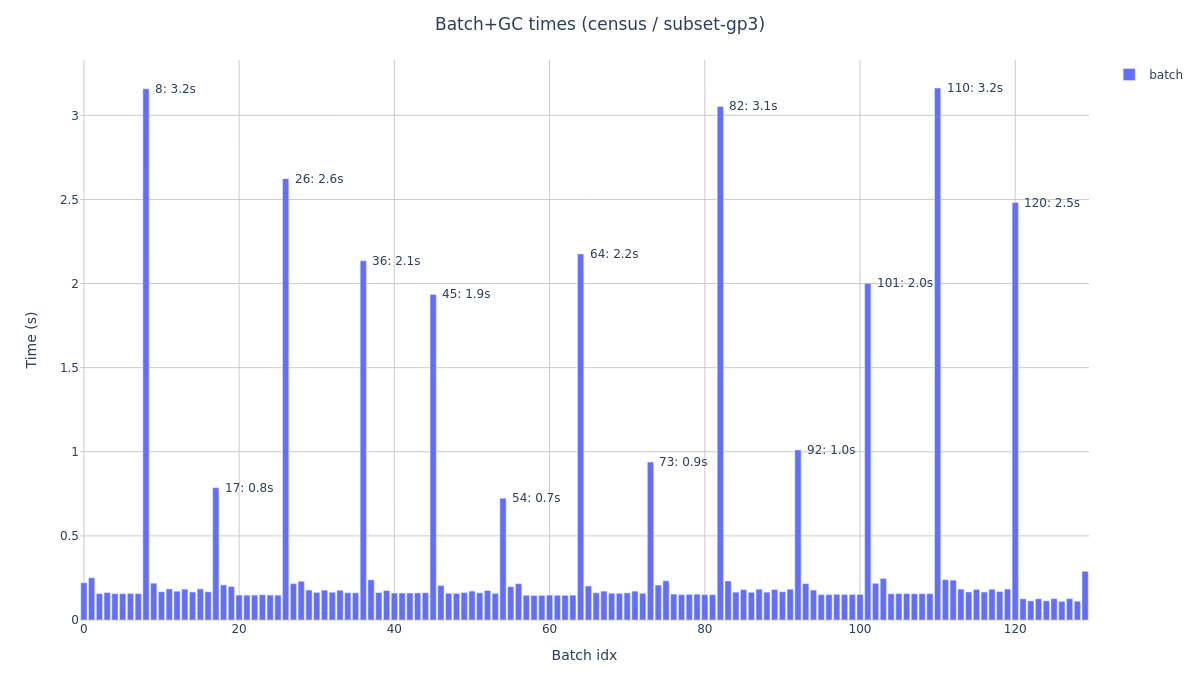

In [52]:
fig = px.bar(
    df.set_index('idx')[['batch', *(['gc'] if 'gc' in df else [])]],
    barmode='stack',
    labels={
        'idx': 'Batch idx',
        'variable': '',
        'value': 'Time (s)',
    },
    log_y=log_plot,
).update_layout(
    title=dict(text=f'Batch+GC times ({method} / {name})'),
).update_xaxes(
    range=(-.5, len(df) - 1 + .5),
)

if not ann.empty:
    anns = ann.set_index('idx').batch.to_dict().items()
    for idx, batch in anns:
        fig.add_annotation(
            x=idx, y=log10(batch) if log_plot else batch,
            showarrow=False,
            text=f'{idx}: {batch:.1f}s',
            xshift=7,
            xanchor='left',
        )

plot(fig, f'census-{name}', fmt='png', save=['png'], w=width, h=height, dir='../img',)